# Яндекс Недвижимость

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [9]:
import pandas as pd
import re
import random
import math
import numpy as np
# from IPython.core.display_functions import display

import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
import requests
from api_key import api_key
import json
from geopy import distance

ModuleNotFoundError: No module named 'api_key'

<div class="alert alert-info" role="alert">
    <p class="mb-0">В коде использую <code>display()</code>, потомучто это однозначно даёт понять что планируется вывод / печать результатов. То есть использую <code>display()</code> намеренно, хотя понимаю что можно и без него выводить данные. 👌</p>
</div>

In [ ]:
pd.__version__

In [ ]:
# set max columns to none
pd.set_option("display.max_columns", None)

In [ ]:
pulkovo_long_lat = (30.270441, 59.799816)
hares_island_long_lat = (30.321948, 59.951103)

if type of location not set assumming that its town

Функция разделяет название населённого пункта на имя и тип. Предпологается, что имя с большой буквы…

In [ ]:
def name_n_type(text):
        whole_words = text.split()
        type_list = []
        name_list = []
        name_loc = " "
        type_loc = " "
        
        # regex
        pattern = '[А-ЯЁ]+[а-яё]'
        
        for word in whole_words:
            
            # searching pattern
            if re.search(pattern, word):
                name_list.append(word)
            else:
                type_list.append(word)
        
        name_loc = name_loc.join(name_list)
        
        if len(type_list) == 0:
            type_loc = 'город'
        else:
            type_loc = type_loc.join(type_list)
        
        return name_loc, type_loc

In [ ]:
def correct_name(to_correct):
    if 'поселок' in to_correct:
        to_correct = to_correct.replace('поселок', 'посёлок')
    return to_correct

In [ ]:
def get_length_2_arprt(
        locality_name,
        locality_type,
        region='ленинградская область'):

    address = (region, locality_type, locality_name)
    address = ', '.join(address)
    maps_url = 'https://geocode-maps.yandex.ru/1.x/'
    keys = {'apikey': api_key,
            'geocode': address,
            'format': 'json',
            'results': '1',
            }

    row_data = requests.get(maps_url, params=keys)
    parsed = json.loads(row_data.text)
    locality_position = (json.dumps(
        parsed['response']['GeoObjectCollection']
        ['featureMember'][0]['GeoObject']['Point']['pos']
        , indent=4, ensure_ascii=False
    )
    )
    locality_position = locality_position.replace('\"', '')
    long, lat = locality_position.split(' ')
    locality_long_lat = (float(long), float(lat))
    dist_in_m = distance.distance(
        locality_long_lat,
        pulkovo_long_lat
    ).m
    return (float(round(dist_in_m)))

In [ ]:
real_estate_data = pd.read_csv('./datasets/real_estate_data.csv', sep='\t')

In [ ]:
display(real_estate_data['balcony'].unique())

In [ ]:
display(real_estate_data.head())

`'cityCenters_nearest'` → convert to snake case

In [ ]:
real_estate_data.rename(columns={'cityCenters_nearest': 'city_centers_nearest'}, inplace=True)

In [ ]:
display(real_estate_data['is_apartment'].unique())

In [ ]:
display(real_estate_data['balcony'].unique())

<div class="alert alert-info" role="alert">
    <p class="mb-0">Как получить <code>list</code> колонок с <code>NaN</code> нашёл на <code>stackoverflow</code> 👌</p>
</div>

<div class="alert alert-info" role="alert">
    <p class="mb-0">Как получить <code>list</code> колонок с <code>NaN</code> нашёл на <code>stackoverflow</code> 👌</p>
</div>

In [ ]:
display(
    real_estate_data.columns[real_estate_data.isna().any()].tolist()
)

Добро, вот с этими колонками нужно разобраться в них пропуски — `NaN`

In [ ]:
display(real_estate_data.info())

In [ ]:

for column in real_estate_data.columns:
    count_of_nan = len(real_estate_data.loc[real_estate_data[column].isna()][column])
    if count_of_nan > 0:
        print(column, end=' NaN = ')
        print(count_of_nan)
        print(real_estate_data[column].describe(), end='\n\n')

## Шаг 2. Предобработка данных

### Определяем и изучаем пропущенные значения:

In [ ]:
display(
    real_estate_data.columns[real_estate_data.isna().any()].tolist()
)

    ❌ 'ceiling_height' — сделаем `NaN` медианным значением по району
    ❌ 'floors_total' — сделаем `NaN` медианным значением по району
    ❌ 'living_area' — сделаем `NaN` медианным значением по диапазонам цен и рай
    ❌ 'is_apartment'
    ❌ 'kitchen_area' — если студия то кухня `NaN` проверим, если да то сделаем 0
    ❌ 'balcony'
    ❌ 'locality_name' — сначала удалим неявные дубликаты
    ❌ 'airports_nearest' — проверим по районам, может и нет ближайших аэропортов тогда `NaN` = 0
    ❌ 'city_centers_nearest' — проверим по районам, может и нет ближайших центров города тогда `NaN` = 0
    ❌ 'parks_around3000' — проверим по районам, может и нет ближайших парков тогда `NaN` = 0
    ❌ 'parks_nearest'
    ❌ 'ponds_around3000' — проверим по районам, может и нет ближайших прудов тогда `NaN` = 0
    ❌ 'ponds_nearest'
    ❌ 'days_exposition' — посмотрим как связан столбец с `first_day_exposition`

#### `is_apartment` NaN ❌

Скорее всего в `'is_apartment'` `NaN` там, где не отмечено `True`. То есть `NaN` — это просто `False`

In [ ]:
real_estate_data['is_apartment'].fillna(value=False, inplace=True)

#### `floor` NaN ❌

Проверим как связаны этаж и наличие балкона. Скорее всего, на первом этаже нет балкона.

In [ ]:
display(
    real_estate_data['floor'].loc[
        (real_estate_data['balcony'].isna())
    ].describe()
)

display(
    real_estate_data['floor'].loc[
        ~(real_estate_data['balcony'].isna())
    ].describe()
)

display(
    real_estate_data['floor'].loc[
        (real_estate_data['balcony'].isna())
        & (real_estate_data['floor'] == 1)
    ].count()
)

#### `balcony` NaN ❌

In [ ]:
(
    real_estate_data['balcony'].loc[
        (real_estate_data['balcony'].isna())
        & (real_estate_data['floor'] == 1)
    ].fillna(value=0, inplace=True)
)

In [ ]:
display(
    real_estate_data['balcony'].unique()
)

Временно заменим `NaN`в `balcony` на 108.

In [ ]:
real_estate_data['balcony'].fillna(value=108, inplace=True)

In [ ]:
display(
    real_estate_data['balcony'].unique()
)

<hr>

#### `is_apartment` NaN ❌

Скорее всего в `'is_apartment'` `NaN` там, где не отмечено `True`. То есть `NaN` — это просто `False`

In [ ]:
real_estate_data['is_apartment'].fillna(value=False, inplace=True)

✔️ `'is_apartment'`

<hr>

#### `locality_name` NaN ❌

In [ ]:
display(
    real_estate_data.loc[real_estate_data['locality_name'].isna()]
                        .head(10)
)

**Предполагаю:**

что стоит заменить пропущенные высоту потолков и количество этажей на медиану районных значений.

##### `'locality_name'` — сначала удалим неявные дубликаты

In [ ]:
real_estate_data['locality_name'].describe()

Заменим `NaN` в `'locality_name'` → на `'Санкт-Петербург'`.

Пропусков всего 49 и `'Санкт-Петербург'` самое популярное значение. 

In [ ]:
real_estate_data['locality_name'].fillna('Санкт-Петербург', inplace=True)

Функция `correct_name` меняет `'поселок'` на `'посёлок'`.

In [ ]:
print('уникальных названий всего:')
print('используются поселок и посёлок:', len(real_estate_data['locality_name'].unique()))
real_estate_data['locality_name'] = real_estate_data['locality_name'].apply(correct_name)
print('используется только посёлок:', len(real_estate_data['locality_name'].unique()))

type of location:
'деревня'
'садовое товарищество'
'городской посёлок'
'посёлок городского типа'
'коттеджный посёлок'
'посёлок при железнодорожной станции'
'посёлок станции'
'посёлок'
'село'
'садоводческое некоммерческое товарищество'

##### Добавим столбец с типом населённого пункта

Функция `name_n_type` делит название `'locality_name'` на **название** и **тип** населённого пункта.

In [ ]:
real_estate_data['locality_name'], real_estate_data['locality_type'] = (
    zip(*real_estate_data['locality_name']
    .apply(name_n_type))
)

In [ ]:
display(
    real_estate_data.head()
)

In [ ]:
display(
    real_estate_data['locality_type'].unique()
)

In [ ]:
real_estate_data.loc[real_estate_data['locality_name'] == 'посёлок 69-й километр', 'locality_name'] = '69-й километр'
real_estate_data.loc[real_estate_data['locality_type'] == 'посёлок 69-й километр', 'locality_type'] = 'посёлок'

In [ ]:
display(
    real_estate_data['locality_type'].unique()
)

Сделаем справочник по типам населённых пунктов.

In [ ]:
locality_type_series = pd.Series(real_estate_data['locality_type'].unique())
display(
    locality_type_series
)

<hr>

Переведём строковый тип населённого пункта `'locality_type'` в числовой.

In [ ]:
real_estate_data['locality_type'] = (
    real_estate_data['locality_type'].apply(lambda x: 
        list(locality_type_series[locality_type_series == x].index)[0]
    )
)

In [ ]:
display(
    real_estate_data.head()
)

In [ ]:
real_estate_data = real_estate_data.astype(
    {
        'locality_name': 'category',
        'locality_type': 'category',
    }
)

Жаль что нет параметра `inplace` у функции `astype()`

In [ ]:
display(
    real_estate_data['balcony'].unique()
)

In [ ]:
display(
    real_estate_data.groupby(by=['locality_type'])['balcony'].median()
)

In [ ]:
types_na_balcony = (
    list(real_estate_data['locality_type']
             .loc[real_estate_data['balcony'] == 108]
             .unique())
)

for type_loc in types_na_balcony:
    
    balcony_mode_by_type = (
        real_estate_data
            .loc[(real_estate_data['locality_type'] == type_loc)
                & ~(real_estate_data['balcony'] == 108), ['balcony']]
            .mode()
    )
    
    if len(balcony_mode_by_type.index) == 0:
        balcony_mode_by_type = 0
    elif len(balcony_mode_by_type.index) == 1:
        balcony_mode_by_type = balcony_mode_by_type.iloc[0].item()
    else:
        balcony_mode_by_type = balcony_mode_by_type.sample().iloc[0].item()
    
    real_estate_data.loc[(real_estate_data['locality_type'] == type_loc)
                & (real_estate_data['balcony'] == 108), 'balcony'] = (
        real_estate_data
            .loc[(real_estate_data['locality_type'] == type_loc)
                & (real_estate_data['balcony'] == 108), 'balcony']
            .apply(lambda x: balcony_mode_by_type if bool(random.getrandbits(1)) else 0)
    )


display(
    real_estate_data['balcony'].unique()
)

✔️ `'balcony'`

<hr>

#### `ceiling_height` NaN ❌

Сделаем `NaN` медианным значением `ceiling_height` по типу населённого пункта.

In [ ]:
types_na_ceiling = (
    list(real_estate_data['locality_type']
             .loc[real_estate_data['ceiling_height'].isna()]
             .unique())
)

for type_ceiling in types_na_ceiling:
    
    ceiling_median_by_type = (
        real_estate_data
            .loc[(real_estate_data['locality_type'] == type_ceiling)
                & ~(real_estate_data['ceiling_height'].isna()), 'ceiling_height']
            .median()
    )
    
    if math.isnan(ceiling_median_by_type):
        ceiling_median_by_type = real_estate_data['ceiling_height'].median()

    real_estate_data.loc[
        real_estate_data['locality_type'] == type_ceiling, 
        'ceiling_height'
    ] = real_estate_data.loc[
            real_estate_data['locality_type'] == type_ceiling, 
            'ceiling_height'
        ].fillna(value=ceiling_median_by_type)

# somehow .fillna(inplace=True) didn't work

In [ ]:
display(
    real_estate_data['ceiling_height'].describe()
)

В `'ceiling_height'` есть значения, которые выглядят неправдоподобно.

Например, меньше 2 метров или больше 20 метров…

In [ ]:
types_odd_ceiling = (
    list(real_estate_data.loc[
            (real_estate_data['ceiling_height'] <= 2)
            | (real_estate_data['ceiling_height'] > 60)
            | ((real_estate_data['ceiling_height'] > 6)
                & (real_estate_data['ceiling_height'] < 20)
              ), 'locality_type'
        ].unique()
    )
)

for type_ceiling in types_odd_ceiling:
    
    ceiling_median_by_type = (
        real_estate_data.loc[
            (real_estate_data['locality_type'] == type_ceiling)
                & (real_estate_data['ceiling_height'] <= 6)
                & (real_estate_data['ceiling_height'] > 2)
            , 'ceiling_height'
        ].median()
    )

    display(ceiling_median_by_type)

    if math.isnan(ceiling_median_by_type):
        ceiling_median_by_type = real_estate_data['ceiling_height'].median()

    real_estate_data.loc[
            (real_estate_data['locality_type'] == type_ceiling)
            & (real_estate_data['ceiling_height'] <= 2)
            | (real_estate_data['ceiling_height'] > 60)
            | ((real_estate_data['ceiling_height'] > 6)
                & (real_estate_data['ceiling_height'] < 20)
              )
            , 'ceiling_height'
    ] = ceiling_median_by_type

In [ ]:
display(
    real_estate_data['ceiling_height'].describe()
)

In [ ]:
real_estate_data.loc[
            (real_estate_data['ceiling_height'] >= 20)
            & (real_estate_data['ceiling_height'] <= 60)
            , 'ceiling_height'
] = real_estate_data.loc[
            (real_estate_data['ceiling_height'] >= 20)
            & (real_estate_data['ceiling_height'] <= 60)
            , 'ceiling_height'
    ].apply(lambda x: x / 10)

In [ ]:
display(
    real_estate_data['ceiling_height'].describe()
)

✔️ `'ceiling_height'`

<hr>

#### `floors_total` NaN ❌

сделаем `NaN` медианным значением `floors_total` по типу населённого пункта.

In [ ]:
display(
    real_estate_data.loc[
        real_estate_data['floors_total'].isna()
    ].groupby(by='floor')['floor'].count()
)

Похоже, `'floors_total'` не зависит от `'floor'`.

In [ ]:
display(
    real_estate_data.loc[real_estate_data['floor'] > real_estate_data['floors_total']]
)

Класс, значения `'floor'` не больше `'floors_total'`, явных противоречий нет.

In [ ]:
# display(
#     real_estate_data.loc[
#         real_estate_data['floors_total'].isna()
#     ].sample(10)
# )

In [ ]:
types_na_flrs_ttl = (
    list(real_estate_data.loc[
            (real_estate_data['floors_total'].isna())
            , 'locality_type'
        ].unique()
    )
)

print(types_na_flrs_ttl)

for type_flrs_ttl in types_na_flrs_ttl:
    
    flrs_ttl_median_by_type = (
        real_estate_data.loc[
            (real_estate_data['locality_type'] == type_flrs_ttl)
            & ~(real_estate_data['floors_total'].isna())
            , 'floors_total'
        ].median()
    )

    print(flrs_ttl_median_by_type)
    
    if math.isnan(flrs_ttl_median_by_type):
        flrs_ttl_median_by_type = real_estate_data['floors_total'].median()
        print('NANы', flrs_ttl_median_by_type)
   
    real_estate_data.loc[
            (real_estate_data['locality_type'] == type_flrs_ttl)
            & (real_estate_data['floors_total'].isna())
            , 'floors_total'
    ] = flrs_ttl_median_by_type

🤦‍♂️

In [ ]:
#     why ↓ it's not working in for loop!?
    
    # real_estate_data.loc[
    #     (real_estate_data['locality_type'] == type_flrs_ttl)
    #     & (real_estate_data['floors_total'].isna())
    #     , 'floors_total'
    # ].fillna(value=flrs_ttl_median_by_type, inplace=True)

In [ ]:
display(
        real_estate_data['floors_total'].describe()
)

In [ ]:
display(
    real_estate_data.loc[
        real_estate_data['floor'] > real_estate_data['floors_total']
        , 'floor'
    ].describe()
)

In [ ]:
real_estate_data.loc[
    (real_estate_data['floor'] > real_estate_data['floors_total'])
    , 'floor'
] = real_estate_data.loc[
        (real_estate_data['floor'] > real_estate_data['floors_total'])
        , 'floors_total'
    ]

In [ ]:
display(
    real_estate_data.loc[real_estate_data['floor'] > real_estate_data['floors_total'], 'floor'].count()
)

In [ ]:
real_estate_data = real_estate_data.astype(
    {'floors_total': 'uint8',}
)

✔️ `'floors_total'`

<hr>

#### `living_area` NaN ❌

сделаем `NaN` медианным значением 'living_area' по диапазонам цен и по типу населённого пункта.

In [ ]:
# display(
#     real_estate_data.loc[
#         real_estate_data['living_area'].isna()
#         , 'floor'
#     ].count()
# )

In [ ]:
display(
    real_estate_data['total_area'].describe()
)

In [ ]:
display(
    real_estate_data.loc[
        real_estate_data['total_area'] > 450
    ]
)

In [ ]:
display(
    real_estate_data['living_area'].describe()
)

In [ ]:
types_na_living_area = (
    list(real_estate_data.loc[
            (real_estate_data['living_area'].isna())
            , 'locality_type'
        ].unique()
    )
)

for type_living_area in types_na_living_area:
    
    living_area_median_by_type = (
        real_estate_data.loc[
            (real_estate_data['locality_type'] == type_living_area)
            & ~(real_estate_data['living_area'].isna())
            , 'living_area'
        ].median()
    )
    
    living_part_median_by_type = round(pd.Series(
        real_estate_data.loc[
            (real_estate_data['locality_type'] == type_living_area)
            & (real_estate_data['living_area'] > 8)
            & ~(real_estate_data['living_area'].isna())
            , 'living_area'
        ] / real_estate_data.loc[
            (real_estate_data['locality_type'] == type_living_area)
            & (real_estate_data['living_area'] > 8)
            & ~(real_estate_data['living_area'].isna())
            , 'total_area'
        ]
    ).median(), 2)

    if math.isnan(living_area_median_by_type):
        living_area_median_by_type = real_estate_data['living_area'].median()
        print('NANы')
        
    real_estate_data.loc[
            (real_estate_data['locality_type'] == type_living_area)
            & ((real_estate_data['living_area'].isna())
            | (real_estate_data['living_area'] < 8))
            , 'living_area'
    ] = real_estate_data.loc[
            (real_estate_data['locality_type'] == type_living_area)
            & ((real_estate_data['living_area'].isna())
            | (real_estate_data['living_area'] < 8))
            , 'total_area'
        ].apply(lambda x: x * living_part_median_by_type)

In [ ]:
display(
    real_estate_data['living_area'].describe()
)

✔️ `'living_area'`

<hr>

#### `kitchen_area` NaN ❌

Допустим, если студия то `kitchen_area` → `NaN`, проверим.

Если да, то сделаем `kitchen_area` → 0.

In [ ]:
display(
    real_estate_data.loc[real_estate_data['kitchen_area'].isna()
        , 'living_area'
    ].count()
)

In [ ]:
display(
    real_estate_data.loc[
        (real_estate_data['kitchen_area'].isna())
        & (real_estate_data['studio'])
        , 'living_area'
    ].count()
)

In [ ]:
display(
    real_estate_data.loc[
        ~ (real_estate_data['kitchen_area'].isna())
        & (real_estate_data['studio'])
        , 'living_area'
    ].count()
)

😏

In [ ]:
display(
    real_estate_data.loc[
        (real_estate_data['kitchen_area'].isna())
        & (real_estate_data['is_apartment'])
        , 'living_area'
    ].count()
)

In [ ]:
display(
    real_estate_data.loc[
        ~ (real_estate_data['kitchen_area'].isna())
        & (real_estate_data['is_apartment'])
    ].sample(10)
)

In [ ]:
real_estate_data.loc[
        (real_estate_data['kitchen_area'].isna())
        & ((real_estate_data['studio'])
          | (real_estate_data['is_apartment']))
        , 'kitchen_area'
] = 0

In [ ]:
types_na_kitchen_area = (
    list(real_estate_data.loc[
            (real_estate_data['kitchen_area'].isna())
            , 'locality_type'
        ].unique()
    )
)

for type_kitchen_area in types_na_kitchen_area:
    
    kitchen_area_part_mdn_by_type = round(pd.Series(
        real_estate_data.loc[
            (real_estate_data['locality_type'] == type_kitchen_area)
            & ~(real_estate_data['kitchen_area'].isna())
            , 'kitchen_area'
        ] / real_estate_data.loc[
            (real_estate_data['locality_type'] == type_kitchen_area)
            & ~(real_estate_data['kitchen_area'].isna())
            , 'total_area'
        ]
    ).median(), 2)
    
    if math.isnan(kitchen_area_part_mdn_by_type):
        print('NANы kitchen_area_part_mdn_by_type', type_kitchen_area)
        
    real_estate_data.loc[
            (real_estate_data['locality_type'] == type_kitchen_area)
            & (real_estate_data['kitchen_area'].isna())
            , 'kitchen_area'
    ] = real_estate_data.loc[
            (real_estate_data['locality_type'] == type_kitchen_area)
            & (real_estate_data['kitchen_area'].isna())
            , 'total_area'
        ].apply(lambda x: x * kitchen_area_part_mdn_by_type)

In [ ]:
display(
    real_estate_data['kitchen_area'].describe()
)

✔️ `'kitchen_area'`

<hr>

#### `airports_nearest` NaN ❌

Проверим по типу населённого пункта.

Может и нет ближайших аэропортов тогда `airports_nearest` → `NaN` сделаем 0.

In [ ]:
display(
    real_estate_data['airports_nearest'].describe()
)

In [ ]:
# display(
#     real_estate_data['airports_nearest'].info()
# )

In [ ]:
display(
    real_estate_data.loc[
        real_estate_data['airports_nearest'].isna()
        , 'locality_type'
    ].unique()
)

In [ ]:
real_estate_data.loc[
    real_estate_data['airports_nearest'] <= 3000
    , 'airports_nearest'
] = np.nan

geo :)
Сделаем `DataFrame` расстояниями от центра населённого пункта до аэропорта «Пулково».

Предпоожим, что это единственный аэропорт в Ленинградской Области и Санкт-Петербурге.

In [ ]:
airprt_columns = ('locality_name', 'locality_type', 'airprt_pulkovo')
airprt_pulkovo_nrst = pd.DataFrame(columns=airprt_columns)
airprt_pulkovo_nrst['locality_name'] = real_estate_data['locality_name'].unique()

airprt_pulkovo_nrst['locality_type'] = (
    airprt_pulkovo_nrst['locality_name']
        .apply(lambda x:
            locality_type_series.iloc[
               real_estate_data.loc[
                    real_estate_data['locality_name'] == x
                    , 'locality_type'
                ].sample(1).item()
            ]
        )
)

airprt_pulkovo_nrst['airprt_pulkovo'] = airprt_pulkovo_nrst.apply(
    lambda x: get_length_2_arprt(locality_type=str(x[1]),  locality_name=str(x[0]))
    ,axis=1
)

display(
    airprt_pulkovo_nrst
)

Словарь, на случай если закончились запросы к Yandex.Maps.

In [ ]:
without_geo = {'Санкт-Петербург': 14315.0, 'Шушары': 12114.0, 'Янино-1': 35175.0, 'Парголово': 27207.0, 'Мурино': 30528.0, 'Ломоносов': 55794.0, 'Сертолово': 33605.0, 'Петергоф': 41071.0, 'Пушкин': 17850.0, 'Кудрово': 28907.0, 'Коммунар': 21903.0, 'Колпино': 36388.0, 'Красный Бор': 46244.0, 'Гатчина': 27642.0, 'Фёдоровское': 31725.0, 'Выборг': 190280.0, 'Кронштадт': 57870.0, 'Кировск': 79157.0, 'Новое Девяткино': 33673.0, 'Металлострой': 33632.0, 'Лебяжье': 85865.0, 'Сиверский': 48425.0, 'Молодцово': 92246.0, 'Кузьмоловский': 38805.0, 'Новая Ропша': 45108.0, 'Павловск': 21110.0, 'Пикколово': 17590.0, 'Всеволожск': 47554.0, 'Волхов': 231067.0, 'Кингисепп': 189494.0, 'Приозерск': 120272.0, 'Сестрорецк': 43533.0, 'Куттузи': 22949.0, 'Аннино': 24353.0, 'Ефимовский': 488800.0, 'Плодовое': 100751.0, 'Заклинье': 111442.0, 'Торковичи': 91185.0, 'Первомайское': 79893.0, 'Красное Село': 21392.0, 'Понтонный': 39635.0, 'Сясьстрой': 256016.0, 'Старая': 41209.0, 'Лесколово': 50172.0, 'Новый Свет': 24625.0, 'Сланцы': 250814.0, 'Путилово': 130547.0, 'Ивангород': 230997.0, 'Шлиссельбург': 85869.0, 'Никольское': 58207.0, 'Зеленогорск': 73307.0, 'Сосновый Бор': 130994.0, 'Оржицы': 62089.0, 'Кальтино': 46444.0, 'Романовка': 53296.0, 'Бугры': 29253.0, 'Рощино': 86119.0, 'Кириши': 195596.0, 'Луга': 112837.0, 'Волосово': 93509.0, 'Отрадное': 58156.0, 'Павлово': 67502.0, 'Оредеж': 94884.0, 'Копорье': 135738.0, 'Молодёжное': 97068.0, 'Тихвин': 363078.0, 'Победа': 106560.0, 'Нурма': 85336.0, 'Синявино': 104581.0, 'Тосно': 71468.0, 'Стрельна': 26735.0, 'Бокситогорск': 397866.0, 'Александровская': 197079.0, 'Лопухинка': 95449.0, 'Пикалёво': 434099.0, 'Терволово': 43181.0, 'Советский': 191244.0, 'Подпорожье': 444725.0, 'Петровское': 81636.0, 'Токсово': 43003.0, 'Сельцо': 113022.0, 'Вырица': 38084.0, 'Кипень': 47803.0, 'Келози': 50620.0, 'Вартемяги': 37207.0, 'Тельмана': 38545.0, 'Севастьяново': 132162.0, 'Большая Ижора': 78980.0, 'Агалатово': 40356.0, 'Новогорелово': 11587.0, 'Лесогорский': 196306.0, 'Лаголово': 29116.0, 'Цвелодубово': 97120.0, 'Рахья': 68928.0, 'Белогорка': 45992.0, 'Заводской': 55107.0, 'Новоселье': 21400.0, 'Большие Колпаны': 34343.0, 'Горбунки': 32156.0, 'Батово': 61927.0, 'Заневка': 30089.0, 'Иссад': 231778.0, 'Приморск': 191692.0, 'Мистолово': 34083.0, 'Новая Ладога': 228691.0, 'Зимитицы': 130114.0, 'Барышево': 114926.0, 'Разметелево': 45776.0, 'Свердлова': 40593.0, 'Пеники': 70569.0, 'Рябово': 101811.0, 'Пудомяги': 20058.0, 'Корнево': 58291.0, 'Низино': 43884.0, 'Бегуницы': 109020.0, 'Поляны': 123240.0, 'Мга': 87824.0, 'Елизаветино': 60776.0, 'Кузнечное': 134822.0, 'Колтуши': 44547.0, 'Запорожское': 79018.0, 'Гостилицы': 71972.0, 'Малое Карлино': 7278.0, 'Мичуринское': 85984.0, 'Морозова': 86398.0, 'Песочный': 88151.0, 'Сосново': 72957.0, 'Аро': 44388.0, 'Ильичёво': 73136.0, 'Тайцы': 21796.0, 'Малое Верево': 21382.0, 'Извара': 93307.0, 'Вещево': 145529.0, 'Паша': 310720.0, 'Калитино': 80290.0, 'Ульяновка': 85865.0, 'Чудской Бор': 134235.0, 'Дубровка': 73585.0, 'Мины': 38939.0, 'Войсковицы': 43548.0, 'Коркино': 113887.0, 'Ропша': 45740.0, 'Приладожский': 117497.0, 'Щеглово': 57841.0, 'Гаврилово': 156394.0, 'Лодейное Поле': 373503.0, 'Рабитицы': 104970.0, 'Никольский': 434204.0, 'Кузьмолово': 40057.0, 'Малые Колпаны': 33291.0, 'Петро-Славянка': 26751.0, 'Назия': 146004.0, 'Репино': 58800.0, 'Углово': 57897.0, 'Старая Малукса': 122944.0, 'Меньково': 44754.0, 'Старые Бегуницы': 106739.0, 'Сапёрный': 94240.0, 'Семрино': 27973.0, 'Глажево': 205228.0, 'Кобринское': 39560.0, 'Гарболово': 57689.0, 'Юкки': 30385.0, 'Приветнинское': 100485.0, 'Мануйлово': 162125.0, 'Пчева': 205365.0, 'Цвылёво': 325948.0, 'Мельниково': 122112.0, 'Пудость': 30912.0, 'Усть-Луга': 222531.0, 'Светогорск': 201116.0, 'Любань': 116705.0, 'Селезнёво': 205214.0, 'Каменногорск': 168411.0, 'Кривко': 75697.0, 'Глебычево': 183269.0, 'Парицы': 36148.0, 'Жилпосёлок': 562916.0, 'Войскорово': 33921.0, 'Стеклянный': 56440.0, 'Важины': 430627.0, 'Мыза-Ивановка': 28149.0, 'Русско-Высоцкое': 37727.0, 'Форносово': 38199.0, 'Старая Ладога': 225005.0, 'Житково': 135273.0, 'Виллози': 20780.0, 'Лампово': 53853.0, 'Шпаньково': 55595.0, 'Лаврики': 32934.0, 'Сумино': 92843.0, 'Возрождение': 177566.0, 'Старосиверская': 46211.0, 'Кикерино': 78050.0, 'Старое Хинколово': 50636.0, 'Пригородный': 28993.0, 'Торфяное': 107371.0, 'Будогощь': 246142.0, 'Суходолье': 92057.0, 'Красная Долина': 152144.0, 'Хапо-Ое': 53189.0, 'Дружная Горка': 52524.0, 'Лисий Нос': 35558.0, 'Яльгелево': 36992.0, 'Рождествено': 58092.0, 'Старополье': 200154.0, 'Левашово': 30104.0, 'Сяськелево': 53081.0, 'Камышовка': 146994.0, 'Лесная Поляна': 46710.0, 'Хязельки': 47880.0, 'Жилгородок': 42240.0, 'Ялгино': 340851.0, 'Новый Учхоз': 44620.0, 'Гончарово': 171460.0, 'Почап': 96293.0, 'Сапёрное': 94240.0, 'Платформа': 68493.0, 'Каложицы': 140887.0, 'Фалилеево': 150362.0, 'Пельгора': 112937.0, 'Торошковичи': 119943.0, 'Белоостров': 45330.0, 'Алексеевка': 169198.0, 'Серебрянский': 138481.0, 'Лукаши': 20202.0, 'Тарасово': 80842.0, 'Кингисеппский': 193006.0, 'Ушаки': 75003.0, 'Котлы': 168986.0, 'Сижно': 238349.0, 'Торосово': 82779.0, 'Форт Красная Горка': 104958.0, 'Новолисино': 59515.0, 'Громово': 86634.0, 'Глинка': 28120.0, 'Старая Пустошь': 49271.0, 'Коммунары': 108652.0, 'Починок': 113176.0, 'Вознесенье': 589006.0, 'Разбегаево': 37812.0, 'Гладкое': 66698.0, 'Тёсово-4': 101535.0, 'Бор': 355091.0, 'Коробицыно': 92007.0, 'Большая Вруда': 120252.0, 'Курковицы': 75929.0, 'Кобралово': 24984.0, 'Суоранда': 40220.0, 'Кондратьево': 247473.0, 'Счастье': 30682.0, 'Реброво': 258246.0, 'Тойворово': 50101.0, 'Семиозерье': 118854.0, 'Лесное': 56363.0, 'Совхозный': 446162.0, 'Ленинское': 62068.0, 'Суйда': 36242.0, 'Нижние Осельки': 44339.0, 'Свирь': 436789.0, 'Перово': 169523.0, 'Высоцк': 204984.0, 'Шум': 167635.0, 'Котельский': 169541.0, 'Лужайка': 220989.0, 'Большая Пустомержа': 158569.0, 'Красносельское': 112292.0, 'Вахнова Кара': 320440.0, 'Пижма': 30906.0, 'Кивеннапа Север': 77634.0, 'Ромашки': 102443.0, 'Каськово': 86794.0, 'Куровицы': 41973.0, 'Плоское': 100421.0, 'Кирпичное': 119228.0, 'Ям-Тесово': 93623.0, 'Раздолье': 75413.0, 'Терпилицы': 105090.0, 'Шугозеро': 436666.0, 'Ваганово': 87528.0, 'Пушное': 106081.0, 'Садко': 84687.0, 'Усть-Ижора': 37056.0, 'Выскатка': 243401.0, 'Свирьстрой': 394972.0, 'Кисельня': 208270.0, 'Трубников Бор': 134785.0, 'Высокоключевой': 36944.0, 'Пансионат Зелёный Бор': 116992.0, 'Ненимяки': 54384.0, 'Снегирёвка': 72608.0, 'Рапполово': 39316.0, 'Пустынка': 61528.0, 'Большой Сабск': 154145.0, 'Русско': 212440.0, 'Лупполово': 33824.0, 'Большое Рейзино': 30860.0, 'Малая Романовка': 55468.0, 'Дружноселье': 51307.0, 'Пчевжа': 233813.0, 'Володарское': 130361.0, 'Нижняя': 22336.0, 'Тихковицы': 51005.0, 'Борисова Грива': 81305.0, 'Дзержинского': 117110.0}

In [ ]:
real_estate_data.loc[
    real_estate_data['airports_nearest'].isna()
    , 'airports_nearest'
] = real_estate_data.loc[
        real_estate_data['airports_nearest'].isna()
        , 'locality_name'
    ].apply(lambda x:
                airprt_pulkovo_nrst.loc[
                    airprt_pulkovo_nrst['locality_name'] == x
                    , 'airprt_pulkovo'
                ].item()
            )

In [ ]:
display(
    real_estate_data['airports_nearest'].describe(),
    
    real_estate_data.loc[
        real_estate_data['airports_nearest'] >= 300_000
        , 'airports_nearest'
    ]
)

In [ ]:
# real_estate_data = real_estate_data.astype(
#     {'airports_nearest': 'int32', }
# )

✔️ `'airports_nearest'`

<hr>

#### `city_centers_nearest` NaN ❌

Проверим по типу населённого пункта, может и нет ближайших центров города тогда `city_centers_nearest` → `NaN` = 0.

In [ ]:
display(
    len(real_estate_data.loc[
        ~real_estate_data['city_centers_nearest'].isna()
        , 'locality_name'
    ].unique())
)

In [ ]:
display(
    len(
        real_estate_data.loc[
            real_estate_data['city_centers_nearest'].isna()
            , 'locality_name'
        ].unique()
    )
)

Локаций с пропущенным `'city_centers_nearest'` явно больше…

Для локации `'Санкт-Петербург'` заменим `NaN` на медиану.

In [ ]:
real_estate_data.loc[
    (real_estate_data['city_centers_nearest'].isna())
    & (real_estate_data['locality_name'] == 'Санкт-Петербург')
    , 'city_centers_nearest'
] = real_estate_data.loc[
        (~real_estate_data['city_centers_nearest'].isna())
        & (real_estate_data['locality_name'] == 'Санкт-Петербург')
        , 'city_centers_nearest'
    ].median()

Создадим `DataFrame` где будут имя локации, тип населённого пункта, расстояние до Заячьего Острова в СПб.

In [ ]:
columns = ('locality_name', 'locality_type', 'dist_to_center')
dist_to_hares_island = pd.DataFrame(columns=columns)

dist_to_hares_island['locality_name'] = (
    real_estate_data.loc[
        real_estate_data['city_centers_nearest'].isna()
        , 'locality_name'
    ].unique()
)
dist_to_hares_island.reset_index(drop=True, inplace=True)

# airprt_pulkovo_nrst['locality_type'] = (
#     airprt_pulkovo_nrst['locality_name']
#         .apply(lambda x:
#                locality_type_series.iloc[
#                    real_estate_data.loc[
#                        real_estate_data['locality_name'] == x
#                        , 'locality_type'
#                    ].sample(1).item()
#                ]
#                )
# )

dist_to_hares_island['locality_type'] = (
    dist_to_hares_island['locality_name']
        .apply(lambda z: locality_type_series.iloc[
                real_estate_data.loc[
                    real_estate_data['locality_name'] == z
                    , 'locality_type'
                ].sample(1).item()
            ]
        )
)

display(
    dist_to_hares_island.sample(7)
)

Функция возвращает расстояние от центра населённого пункта до Заячьего Острова в Санкт-Петербурге.

Конечно, `API` **Yandex.Maps** можно использовать более умело. То есть искать расстояние до центра ближайшего города, а не только до Заячьего Острова. В этом решении только обозначим возможность получить данные, чтобы заполнить `NaN` в `'city_centers_nearest'`.

In [ ]:
def to_hares_island(
        locality_name,
        locality_type,
        region='ленинградская область'):

    address = (region, locality_type, locality_name)
    address = ', '.join(address)
    maps_url = 'https://geocode-maps.yandex.ru/1.x/'
    keys = {'apikey': api_key,
            'geocode': address,
            'format': 'json',
            'results': '1',
            }

    row_data = requests.get(maps_url, params=keys)
    parsed = json.loads(row_data.text)
    locality_position = (json.dumps(
        parsed['response']['GeoObjectCollection']
        ['featureMember'][0]['GeoObject']['Point']['pos']
        , indent=4, ensure_ascii=False
    )
    )
    locality_position = locality_position.replace('\"', '')
    long, lat = locality_position.split(' ')
    locality_long_lat = (float(long), float(lat))
    dist_in_m = distance.distance(
        locality_long_lat,
        hares_island_long_lat
    ).m
    return (float(round(dist_in_m)))

In [ ]:
dist_to_hares_island['dist_to_center'] = dist_to_hares_island.apply(
    lambda x: to_hares_island(locality_type=str(x[1]),  locality_name=str(x[0]))
    ,axis=1
)

In [ ]:
# display(
#     dist_to_hares_island.sample(7)
# )

In [ ]:
real_estate_data.loc[
    real_estate_data['city_centers_nearest'].isna()
    , 'city_centers_nearest'
] = real_estate_data.loc[
        real_estate_data['city_centers_nearest'].isna()
        , ['locality_name', 'locality_type']
    ].apply(lambda x:
                dist_to_hares_island.loc[
                    dist_to_hares_island['locality_name'] == x['locality_name']
                    , 'dist_to_center'
                ].item()
            , axis=1
            )

display(
    real_estate_data['city_centers_nearest'].describe()
)

✔️ `'city_centers_nearest'`

<hr>

#### `parks_around3000` NaN ❌

In [ ]:
display(
    real_estate_data.loc[
        ~(real_estate_data['parks_around3000'].isna())
        & (real_estate_data['locality_name'] == 'Санкт-Петербург')
        # , 'parks_around3000'
    ].groupby(by='parks_around3000')['parks_around3000'].count()
)

In [ ]:
display(
    list(real_estate_data.loc[
             real_estate_data['parks_around3000'].isna(),
             'locality_type'
         ].unique()
     )
)

Для городов заполним `NaN` в `parks_around3000` значениями из выборки.

Для этого посчитаем "вес" или вероятность каждого уникального значения `parks_around3000` для **городов**.

In [ ]:
parks_prbblt_columns = ('parks_nrst', 'items_count', 'item_probability')
parks_probability_df = pd.DataFrame(columns=parks_prbblt_columns)

parks_probability_df['parks_nrst'] = (
    real_estate_data.loc[
        (real_estate_data['locality_type'] == 0)
        & ~(real_estate_data['parks_around3000'].isna())
        , 'parks_around3000'
    ].unique()
)

parks_probability_df['items_count'] = (
    parks_probability_df['parks_nrst'].apply(
        lambda x: real_estate_data.loc[
            (real_estate_data['locality_type'] == 0)
            & (real_estate_data['parks_around3000'] == x)
            , 'parks_around3000'
        ].count()
    )
)

parks_probability_df['item_probability'] = (
    parks_probability_df['items_count'].apply(
        lambda x: round(x / parks_probability_df['items_count'].sum(), 3)
    )
)

In [ ]:
display(
    parks_probability_df
)

Теперь заполним `NaN` в `parks_around3000` значениями из выборки.

Случайным выбором из возможных вариантов. Выбор варианта обусловлен вероятностью его появления в выборке.

In [ ]:
real_estate_data.loc[
    (real_estate_data['locality_type'] == 0)
    & (real_estate_data['parks_around3000'].isna())
    , 'parks_around3000'
] = random.choices(
        parks_probability_df['parks_nrst']
        , weights=parks_probability_df['item_probability']
        , k=len(real_estate_data.loc[
                    (real_estate_data['locality_type'] == 0)
                    & (real_estate_data['parks_around3000'].isna())
                    , 'parks_around3000'
                ]
            )
    )

Для остальных типов населённых пунктов, кроме городов заполним `median()` по типу населённого пункта. Если `median()` опроеделить не возможно, то заполняем `NaN` → `0`. 

In [ ]:
real_estate_data.loc[
    (real_estate_data['locality_type'] != 0)
    & (real_estate_data['parks_around3000'].isna())
    ,'parks_around3000'
] = real_estate_data.loc[
                (real_estate_data['locality_type'] != 0)
                & (real_estate_data['parks_around3000'].isna())
                ,'locality_name'
            ].apply(lambda x: 0
                if np.isnan(real_estate_data.loc[
                            (real_estate_data['locality_name'] == x)
                            , 'parks_around3000'
                        ].median())
                else (real_estate_data.loc[
                          (real_estate_data['locality_name'] == x)
                          , 'parks_around3000'
                      ].median())
            )


In [ ]:
# display(
#     real_estate_data['parks_around3000'].describe()
# )

✔️ `'parks_around3000'`

<hr>

#### `parks_nearest` NaN ❌

In [ ]:
display(
    real_estate_data.loc[real_estate_data['parks_nearest'] <= 10],
    real_estate_data['parks_nearest'].describe()
)

Если парков в округе нет, то поставим заведомо невозможное значение. То есть `8888` м значительно больше `3000` м.

In [ ]:
real_estate_data.loc[(real_estate_data['parks_nearest'].isna())
                    & (real_estate_data['parks_around3000'] == 0)
                    , 'parks_nearest'
] = 8888


In [ ]:
types_na_parks_nrst = pd.Series(
                real_estate_data.loc[
                    real_estate_data['parks_nearest'].isna()
                    , 'locality_name'
                ].unique()
)

display(types_na_parks_nrst)

real_estate_data.loc[real_estate_data['parks_nearest'].isna()
                    , 'parks_nearest'
] = types_na_parks_nrst.apply(lambda pt:
        real_estate_data.loc[
            (real_estate_data['parks_nearest'].isna())
            & (real_estate_data['locality_name'] == pt)
            , 'parks_nearest'
        ].median()
    )

real_estate_data[
    'parks_nearest'
].fillna(value=8888, inplace=True)

# display(
#     real_estate_data['parks_nearest'].describe()
# )

✔️ `'parks_nearest'`

✔️ `''`

<hr>

#### `ponds_around3000` NaN ❌

Проверим по типу населённого пункта, может и нет ближайших прудов тогда `NaN` = 0

In [ ]:
lclt_2_pnds_mdn = list(
    real_estate_data.loc[
        real_estate_data['ponds_around3000'].notna()
        , 'locality_name'
    ].unique()
)

real_estate_data.loc[
    real_estate_data['ponds_around3000'].isna()
    , 'ponds_around3000'
] = real_estate_data.loc[
        real_estate_data['ponds_around3000'].isna()
        , 'locality_name'
    ].apply(lambda lctn:
        round(
            real_estate_data.loc[
                real_estate_data['locality_name'] == lctn
                , 'ponds_around3000'
            ].median()
        ) if lctn in lclt_2_pnds_mdn else 0)

# display(
#   real_estate_data['ponds_around3000'].info()
# )

✔️ `'ponds_around3000'`

<hr>

#### `ponds_nearest` NaN ❌

In [ ]:
lclt_2_pnds_nrst_mdn = list(
    real_estate_data.loc[
        real_estate_data['ponds_nearest'].notna()
        , 'locality_name'
    ].unique()
)

real_estate_data.loc[
    real_estate_data['ponds_around3000'] == 0
    , 'ponds_nearest'
].fillna(8888, inplace=True)

real_estate_data.loc[
    real_estate_data['ponds_nearest'].isna()
    , 'ponds_nearest'
] = real_estate_data.loc[
        real_estate_data['ponds_nearest'].isna()
        , 'locality_name'
    ].apply(lambda lcpn:
                round(
                    real_estate_data.loc[
                        real_estate_data['locality_name'] == lcpn
                        , 'ponds_nearest'
                    ].median()
                )
                if lcpn in lclt_2_pnds_nrst_mdn
                else 8888
            )

# display(
#     real_estate_data['ponds_nearest'].info()
# )

✔️ `'ponds_nearest'`

<hr>

#### `days_exposition` NaN ❌

Посмотрим как связан столбец с `first_day_exposition`

In [ ]:
display(
    real_estate_data.sample(7)
 )

real_estate_data['first_day_exposition'] = (
    pd.to_datetime(real_estate_data['first_day_exposition']
                   , yearfirst=True
                   , format='%Y-%m-%d'
                   )
)

first_last = (
                real_estate_data['first_day_exposition'].max()
                - real_estate_data['first_day_exposition'].min()
)

display(
    # real_estate_data['first_day_exposition'].info()
    real_estate_data['first_day_exposition'].max()
    , real_estate_data['first_day_exposition'].min()
    , real_estate_data['days_exposition'].max()
    , real_estate_data['days_exposition'].min()
    , len(real_estate_data['days_exposition'].unique())
    , first_last.days
    , real_estate_data['days_exposition'].max()
)

display(
    real_estate_data.loc[
        real_estate_data['first_day_exposition']
            == real_estate_data['first_day_exposition'].min()
        , 'days_exposition'
    ]
)

real_estate_data['days_exposition'].fillna(0, inplace=True)

# display(
#     real_estate_data['days_exposition'].info()
# )

✔️ `'days_exposition'`

<hr>

### Приведите данные к нужным типам:

In [ ]:
display(
    real_estate_data.head(7)
    , real_estate_data.info()
)

In [ ]:
real_estate_data = real_estate_data.astype(
                        {
                            'total_images': 'uint8',
                            'last_price': 'uint32',
                            'total_area': 'uint16',
                            # 'first_day_exposition': '',
                            'rooms': 'uint8',
                            'ceiling_height': 'float16',
                            'floors_total': 'uint16',
                            'living_area': 'float32',
                            'floor': 'uint8',
                            'is_apartment': 'bool',
                            'studio': 'bool',
                            'open_plan': 'bool',
                            'kitchen_area': 'float32',
                            'balcony': 'uint8',
                            'locality_name': 'category',
                            'airports_nearest': 'uint32',
                            'city_centers_nearest': 'uint32',
                            'parks_around3000': 'uint8',
                            'parks_nearest': 'uint16',
                            'ponds_around3000': 'uint8',
                            'ponds_nearest': 'uint16',
                            'days_exposition': 'uint16',
                            'locality_type': 'category',
                        }
)


In [ ]:
display(
    real_estate_data.info()
)

**1.9 Mb** спасли заменой типа переменных

<hr>

## Шаг 3. Посчитаем и добавим в таблицу

### ➕ цену квадратного метра

In [ ]:
real_estate_data['square_price'] = (
    round(
        real_estate_data['last_price']
        / real_estate_data['total_area']
        , 2
    )
)

display(
    real_estate_data['square_price'].describe()
    , real_estate_data['square_price'].max()
    , real_estate_data.loc[
        real_estate_data['square_price'] >= 500_000
    ]
)

### ➕ день недели, месяц и год публикации объявления

In [ ]:
real_estate_data['date_name'] = (
    real_estate_data['first_day_exposition'].dt.strftime('%A, %B %Y')
)

display(
    real_estate_data['date_name'].sample(5)
)

### ➕ этаж квартиры

варианты — `первый`, `последний`, `другой`;

In [ ]:
def type_of_floor(floors):
    if floors['floor'] == 1:
        return 'first'
    elif floors['floor'] == floors['floors_total']:
        return 'last'
    else:
        return 'other'


real_estate_data['floor_type'] = (
    real_estate_data.loc[:
        , ('floor', 'floors_total')
    ].apply(type_of_floor, axis=1)
)

display(
    real_estate_data['floor_type'].describe()
)

### ➕ отношение жилой и общей площади

In [ ]:
real_estate_data.loc[
    real_estate_data['living_area']
    > real_estate_data['total_area']
    , 'living_area'
] = real_estate_data.loc[
        real_estate_data['living_area']
        > real_estate_data['total_area']
        , 'total_area'
    ]

In [ ]:
real_estate_data['living_2_total'] = (
    round(
        real_estate_data['living_area']
        / real_estate_data['total_area']
        , 2
    )
)

display(
    real_estate_data['living_2_total'].describe()
)

### ➕ отношение площади кухни к общей площади

In [ ]:
real_estate_data['kitchen_2_total'] = (
    round(
        real_estate_data['kitchen_area']
        / real_estate_data['total_area']
        , 2
    )
)

display(
    real_estate_data['kitchen_2_total'].describe()
)

In [ ]:
real_estate_data = real_estate_data.astype(
    {
        # 'date_name': '',
        'floor_type': 'category',
        'living_2_total': 'float16',
        'kitchen_2_total': 'float16',

    }
)

In [ ]:
display(
    real_estate_data.info()
)

In [ ]:
display(
    real_estate_data.duplicated().sum()
)

## Шаг 4. Проведём исследовательский анализ данных по инструкции

#### 📊 площадь

In [ ]:
f, ax = plt.subplots(figsize=(15, 8))
sns.despine(f)
plt.title ('площадь', fontsize=22)
plt.xlabel('last price', fontsize=18)
plt.ylabel('количество', fontsize=18)
sns.histplot(
    real_estate_data['total_area'],
    edgecolor=".3",
    linewidth=.5,
    log_scale=(False, False),
)


<hr>

#### 📊 цена

In [ ]:
import matplotlib as mpl

sns.set_theme(style="ticks")

print(
    real_estate_data['last_price'].describe()
)
print(
    real_estate_data['last_price'].max()
)

print(
    real_estate_data['last_price'].median()
)

f, ax = plt.subplots(figsize=(15, 8))
sns.despine(f)
plt.title ('цена', fontsize=22)
plt.xlabel('last price', fontsize=18)
plt.ylabel('количество', fontsize=18)
sns.histplot(
    real_estate_data['last_price'],
    edgecolor=".3",
    linewidth=.5,
    log_scale=(True, True),
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([12190, 4_650_000, 100_000_000, 763_000_000])

<hr>

#### 📊 число комнат

In [ ]:
f, ax = plt.subplots(figsize=(15, 8))
sns.despine(f)
plt.title ('число комнат', fontsize=22)
plt.xlabel('rooms', fontsize=18)
plt.ylabel('количество', fontsize=18)
sns.histplot(
    real_estate_data['rooms'],
    discrete='True',
    linewidth=.5,
    log_scale=(False, True),
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

<hr>

#### 📊 высота потолков

In [ ]:
f, ax = plt.subplots(figsize=(15, 8))
sns.despine(f)
plt.title ('высота потолков', fontsize=22)
plt.xlabel('ceiling_height', fontsize=18)
plt.ylabel('количество', fontsize=18)
sns.histplot(
    real_estate_data['ceiling_height'],
    bins=15,
    binwidth=0.25,
    # edgecolor=".3",
    discrete='True',
    linewidth=.5,
    log_scale=(False, True),
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

<hr>

### Время продажи квартиры.

#### 📊 Построим гистограмму

In [ ]:
to_plot = real_estate_data.loc[
    real_estate_data['days_exposition'] != 0
    , 'days_exposition'
]

f, ax = plt.subplots(nrows=2, sharex=True, figsize=(15, 16))
f.suptitle('время продажи')
ax[0].set_title('histogram')
sns.histplot(
    data=to_plot,
    ax=ax[0],
    bins=15,
    binwidth=0.25,
    # edgecolor=".3",
    discrete='True',
    linewidth=.5,
    log_scale=(False, True)
)
ax[1].set_title('barplot')
sns.boxplot(
    x=to_plot,
    ax=ax[1],
    orient=1
)

#### Посчитаем среднее и медиану

#### Сколько обычно занимает продажа

#### Когда продажи прошли очень быстро, а когда необычно долго?

Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили.

In [8]:
display(
    (to_plot.describe()['std'] * 3)
    + to_plot.describe()['50%'],

    to_plot.describe()

)

display(
    to_plot.mode()
)

NameError: name 'to_plot' is not defined

### Факторы, которые больше всего влияют на стоимость квартиры

#### 🔎 Зависит ли цена от площади

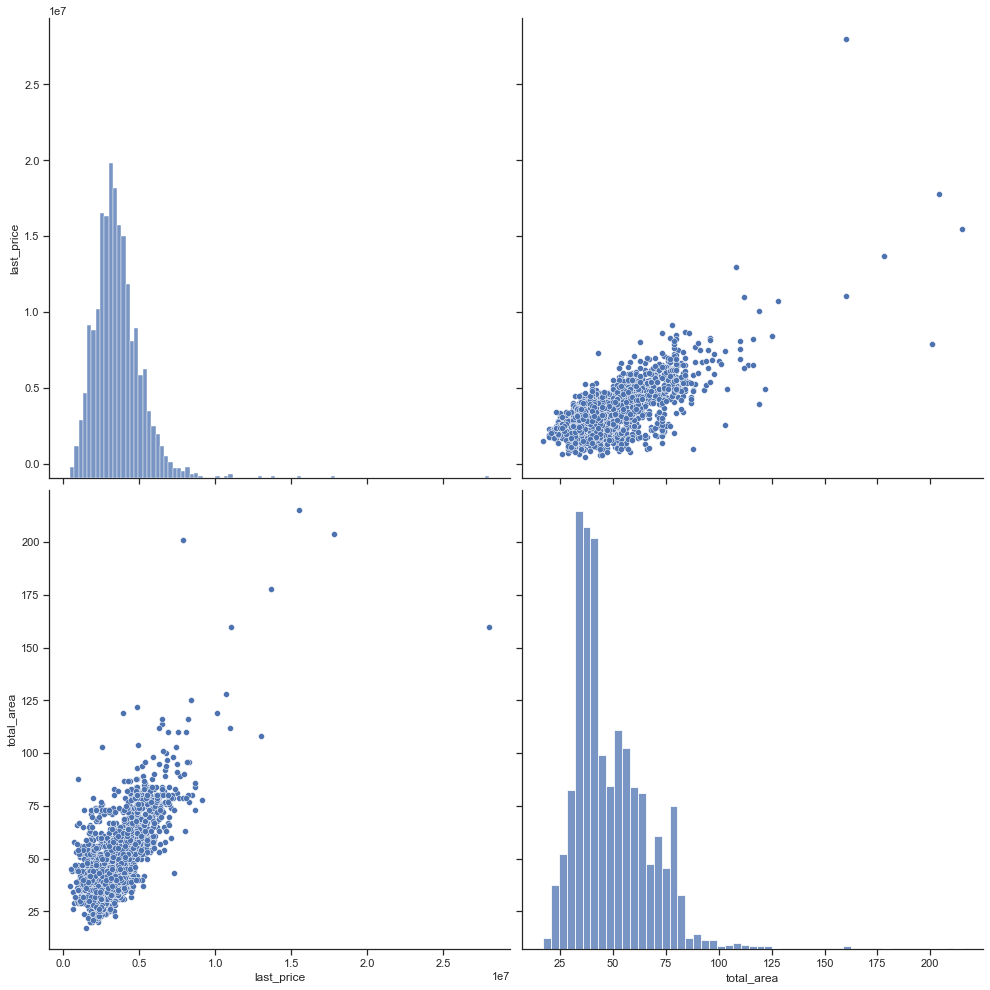

In [400]:
sns.pairplot(data=real_estate_data.loc[
                    real_estate_data['locality_type'] == 1
                    , ['last_price', 'total_area']
                ],
             height=7,
             aspect=1,
             )

#### 🔎 Зависит ли цена от числа комнат

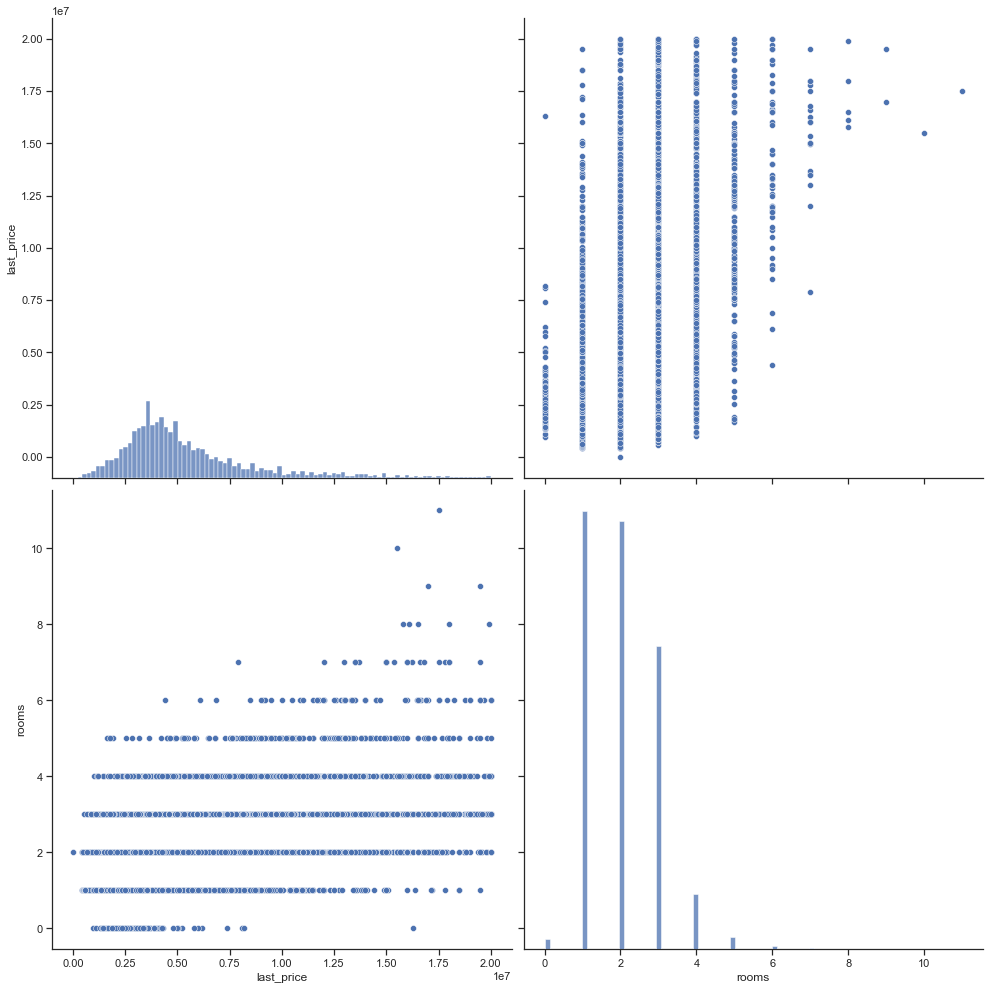

In [490]:
sns.pairplot(data=real_estate_data.loc[
                    # :
                    (real_estate_data['last_price']
                        <= 200_000_000
                    )
                   #  & (real_estate_data['last_price']
                   #     <= real_estate_data['last_price']
                   #     .describe()['75%']
                   # )
                    , ['last_price', 'rooms']
                  ],
            height=7,
            aspect=1,
         )

В целом видно что зависимость цены от числа комнат есть, но разброс цен очень большой для каждого количества комнат. Логика подсказывает что местоположение вносит эти «шумы».

#### 🔎 Зависит ли цена от удалённости от центра

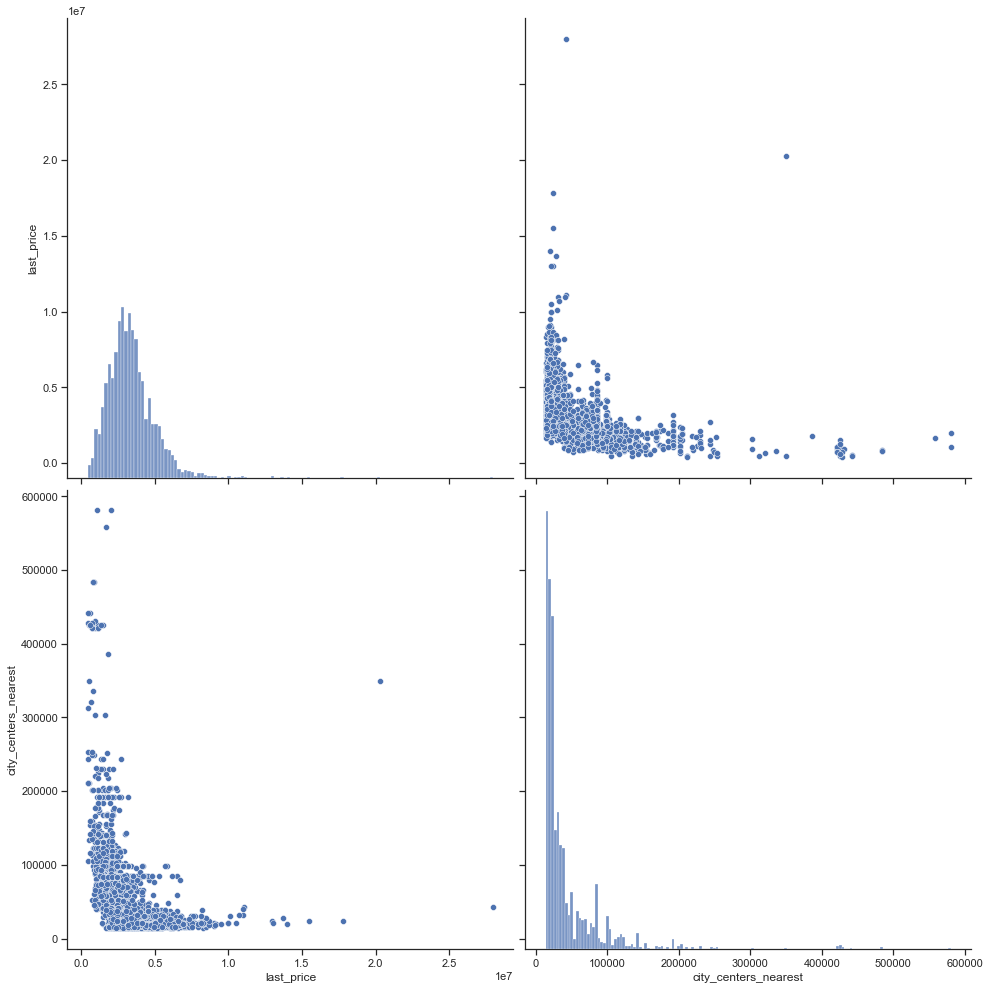

In [470]:
sns.pairplot(data=real_estate_data.loc[
    real_estate_data['locality_type'] != 0
    , ['last_price', 'city_centers_nearest']
],
             height=7,
             aspect=1,
             )

Очень похоже на обратную корреляцию ну и по логике оно так. Но хорошо бы сравнивать зависимость цены от удалённости при прочих равных: площадь, количество комнат, высота потолков.

#### 🔎 Зависит ли цена от этажа квартиры: первый, последний или другой

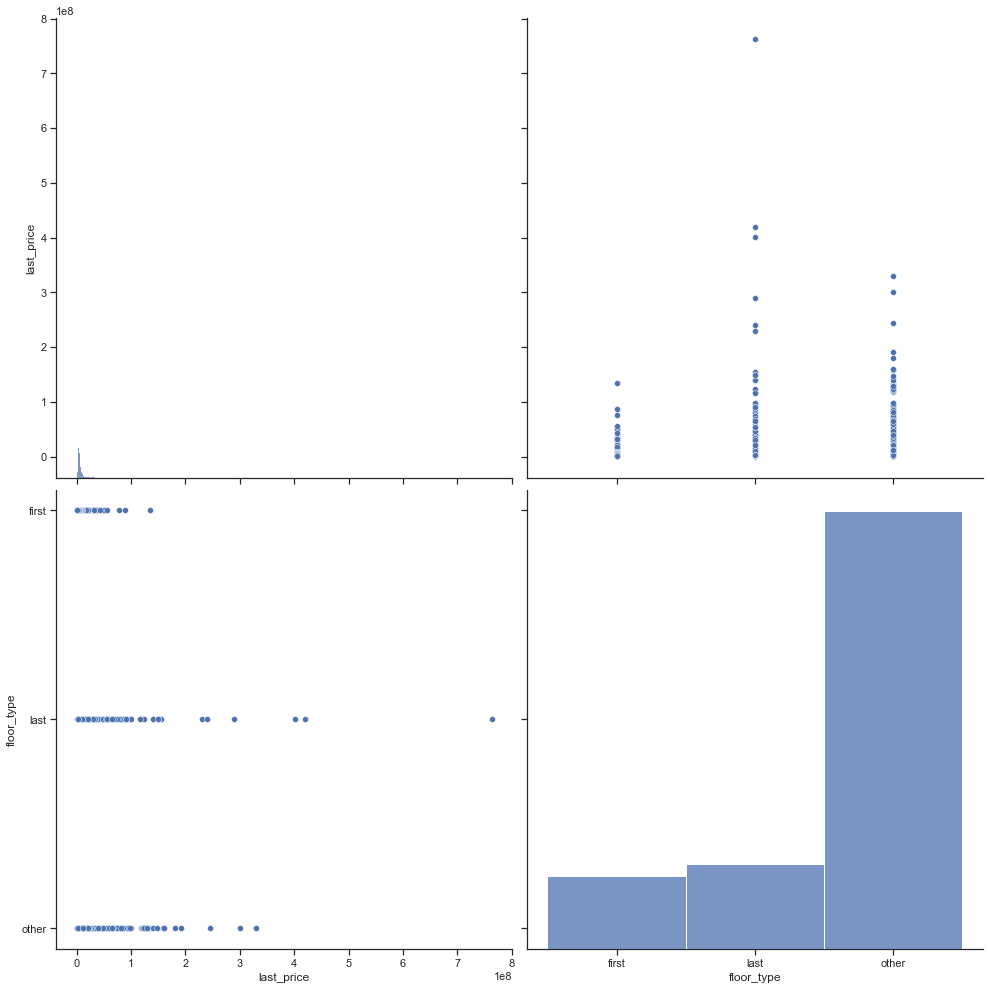

In [483]:
# to_plot = pd.DataFrame(real_estate_data.loc[: , ['last_price', 'floor_type']])

sns.pairplot(data=real_estate_data,
    vars=['last_price', 'floor_type'],

        # , ['last_price', 'floor_type']
    height=7,
    aspect=1,
)



Трудно сказать о зависимости цены от этажа, но видно что цена за `последние` этажы может быть выше чем за `другие` и `первые` этажи. Считаю, что нужно сравнивать при прочих равных…

#### 🔎 Зависит ли цена от даты размещения: дня недели, месяца и года

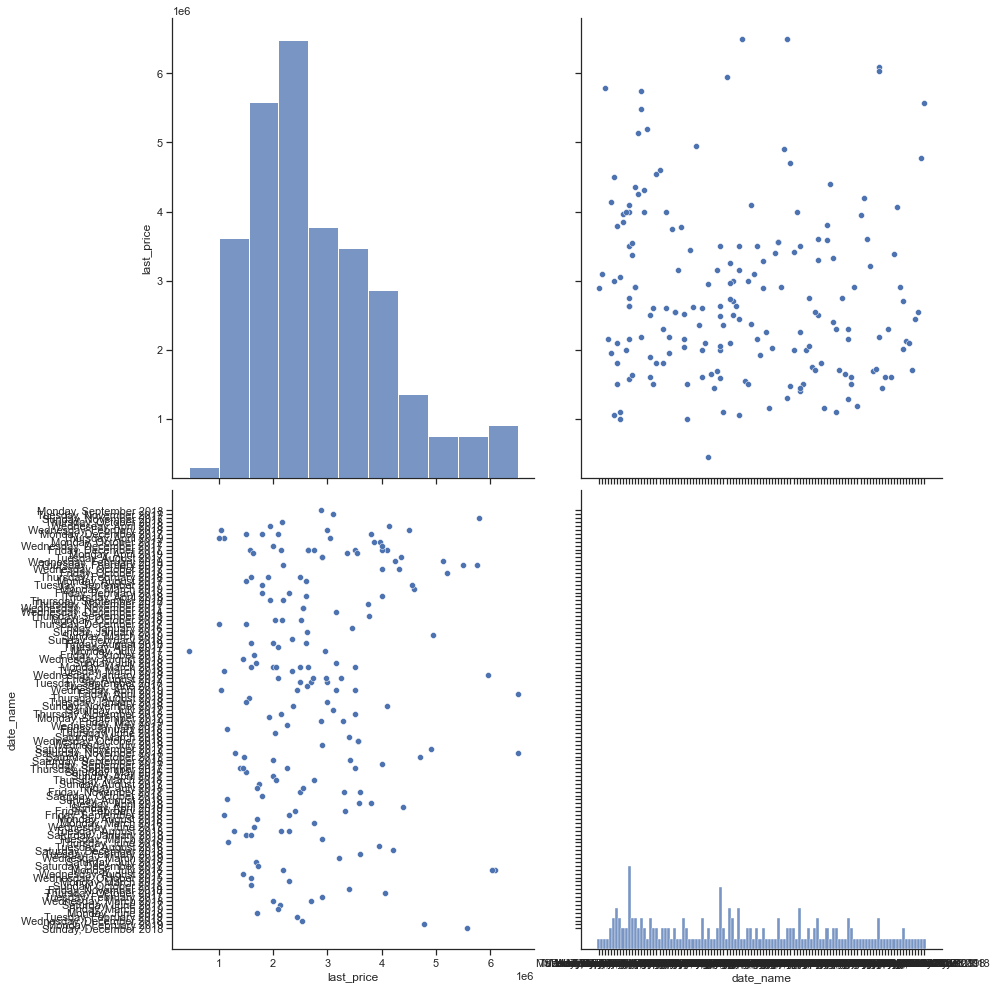

In [415]:
# to_plot = pd.DataFrame(real_estate_data.loc[: , ['last_price', 'floor_type']])

sns.pairplot(data=real_estate_data.loc[
            real_estate_data['locality_type'] == 2
        ],
    vars=['last_price', 'date_name'],

        # , ['last_price', 'floor_type']
    height=7,
    aspect=1,
)
# real_estate_data['first_day_exposition'].dt.strftime('%A, %B %Y')


Похоже, что не зависит цена от даты публикации

<hr>

### 10 населённых пунктов с наибольшим числом объявлений

#### 🧮 Средняя цена квадратного метра в TOP 10 населённых пунктах

In [430]:
top_ten = pd.DataFrame(
    real_estate_data.groupby(by='locality_name')['last_price']
        .count()
        .sort_values(ascending=False)
        .head(10)
)

top_ten.reset_index(inplace=True)
top_ten.rename(columns = {'last_price':'advert_count'}, inplace=True)

top_ten['median_price'] = top_ten['locality_name'].apply(
    lambda nm: real_estate_data.loc[
        real_estate_data['locality_name'] == nm
        , 'last_price'
    ].median()
)

display(top_ten.sort_values(by='median_price', ascending=False))


,locality_name,advert_count,median_price
0,Санкт-Петербург,15770,5500000.0
5,Пушкин,369,5180000.0
7,Парголово,327,4100000.0
3,Шушары,440,3950000.0
2,Кудрово,472,3890000.0
6,Колпино,338,3600000.0
4,Всеволожск,398,3450000.0
1,Мурино,590,3400000.0
8,Гатчина,307,3100000.0
9,Выборг,237,2897000.0


#### 🧮 Населённые пункты с самой высокой и низкой стоимостью жилья

Если выбирать из **10 самых популярных** населённых пунктов, то:

Санкт-Петербург → самая высокая медианная стоимость.

Выборг → самая низкая медианная стоимость.

<hr>

### Квартиры в Санкт-Петербурге

#### 🔎 Какая область входит в центр

#### ➕ Столбец с расстоянием до центра в километрах

In [437]:
spb_center = pd.DataFrame(
    real_estate_data.loc[
        real_estate_data['locality_name'] == 'Санкт-Петербург'
        ,['last_price', 'city_centers_nearest']
    ]
)

spb_center.reset_index(drop=True, inplace=True)

spb_center['city_centers_nearest'] = spb_center['city_centers_nearest'].apply(
    lambda mtr: round(mtr / 1000)
)

display(spb_center)

,last_price,city_centers_nearest
0,13000000,16
1,5196000,14
2,64900000,7
3,10000000,8
4,7915000,12
...,...,...
15765,3550000,16
15766,5500000,6
15767,9470000,4
15768,9700000,4


#### 🧮 Определим менианную цену для каждого километра

,km_to_center,last_price
0,0,17900000.0
1,1,11490000.0
2,2,10000000.0
3,3,8409000.0
4,4,9200000.0
5,5,9490000.0
6,6,8900000.0
7,7,7800000.0
8,8,7440000.0
9,9,5300000.0


<AxesSubplot:xlabel='km_to_center', ylabel='last_price'>

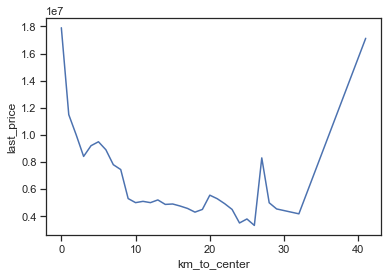

In [444]:
spb_price_for_km = pd.DataFrame(
    spb_center.groupby(by='city_centers_nearest')
    ['last_price']
    .median()
)

spb_price_for_km.reset_index(inplace=True)
spb_price_for_km.rename(columns = {'city_centers_nearest':'km_to_center'}, inplace=True)

display(
    spb_price_for_km
)

sns.lineplot(x="km_to_center", y="last_price",
             data=spb_price_for_km)

#### 📊 Как цена зависит от удалённости от центра

На графике ↑ видно, что до 25–ти км цена снижается при удалении от центра, а вот дальше начинает увеличиваться, но как–то не очень равномерно. Выбросы…?

#### 🔎 Определим границу, где график сильно меняется, — это и будет центральная зона

На 8-ом км медианная цена меняется с 5,3 млн ₽ до 7,44 млн ₽. Похоже, что это граница «центра».

<hr>

### Выделим сегмент квартир в центре

#### 🔎 🎯 Площадь

#### 🔎 🎯 Цена

#### 🔎 🎯 Число комнат

#### 🔎 🎯 Высота потолков

<AxesSubplot:title={'center':'ceiling_height'}, xlabel='ceiling_height', ylabel='Count'>

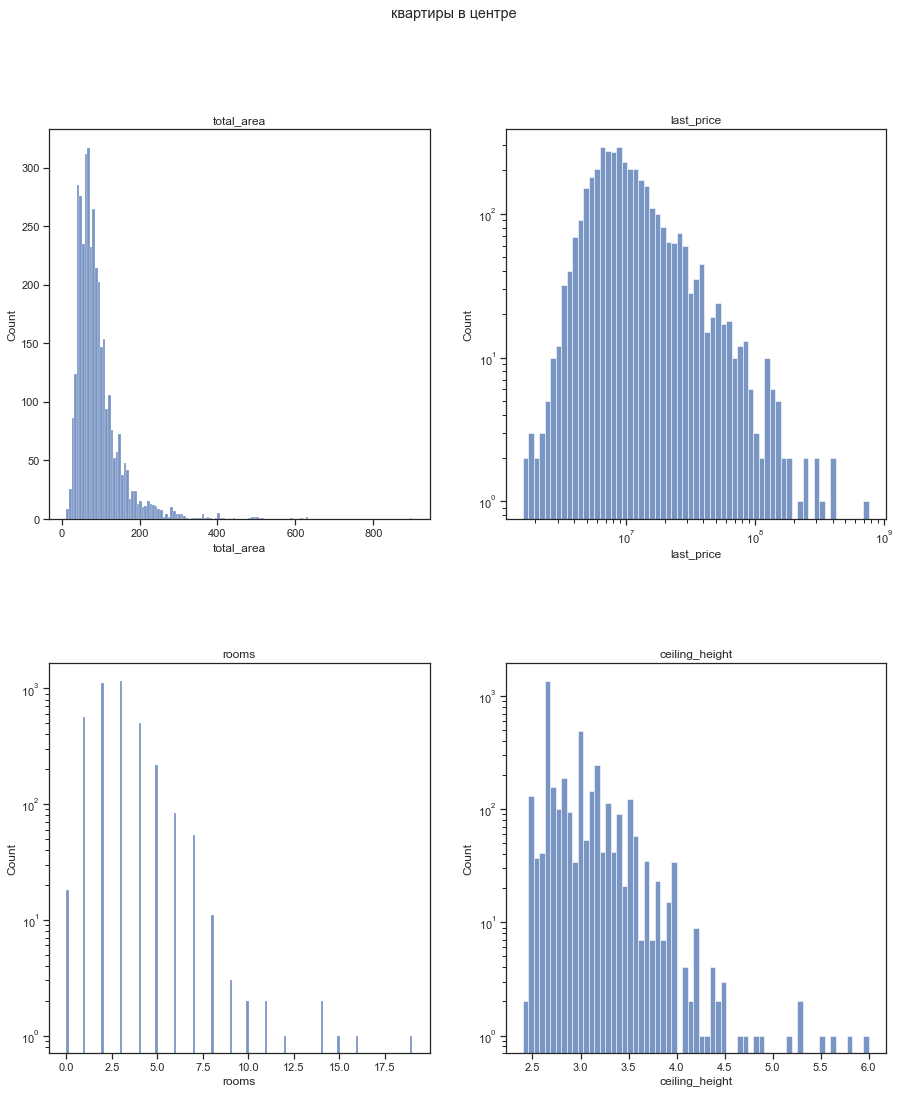

In [468]:
to_plot = (
    real_estate_data.loc[
        (real_estate_data['locality_name'] == 'Санкт-Петербург')
        & (real_estate_data['city_centers_nearest'] <= 8000)
        , ['total_area',
           'last_price',
           'rooms',
           'ceiling_height',
           'floor',
           'city_centers_nearest',
           'first_day_exposition'
        ]
    ]
)

f, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 17), gridspec_kw={'hspace': 0.37, })
f.suptitle('квартиры в центре')

ax[0, 0].set_title('total_area')
sns.histplot(
    data=to_plot['total_area'],
    ax=ax[0, 0],
)
ax[0, 1].set_title('last_price')
sns.histplot(
    data=to_plot['last_price'],
    ax=ax[0, 1],
    log_scale=(True, True),
)
ax[1, 0].set_title('rooms')
sns.histplot(
    data=to_plot['rooms'],
    ax=ax[1, 0],
    log_scale=(False, True)
)
ax[1, 1].set_title('ceiling_height')
sns.histplot(
    data=to_plot['ceiling_height'],
    ax=ax[1, 1],
    log_scale=(False, True)
)

<hr>

### Выделим факторы, которые влияют на стоимость квартиры

Сделайте выводы. Отличаются ли они от общих выводов по всей базе?

#### 🔎 число комнат

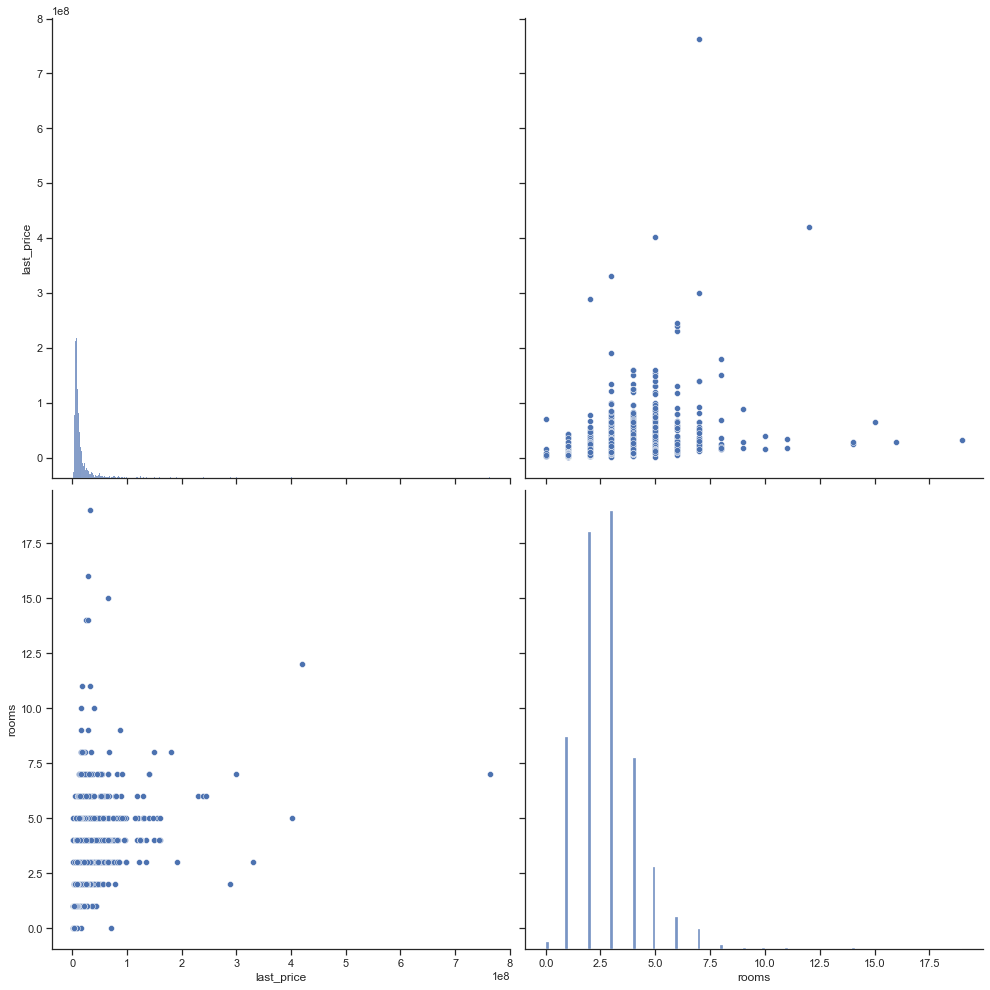

In [469]:
sns.pairplot(data=to_plot,
    vars=['last_price', 'rooms'],
    height=7,
    aspect=1,
)

#### 🔎 этаж

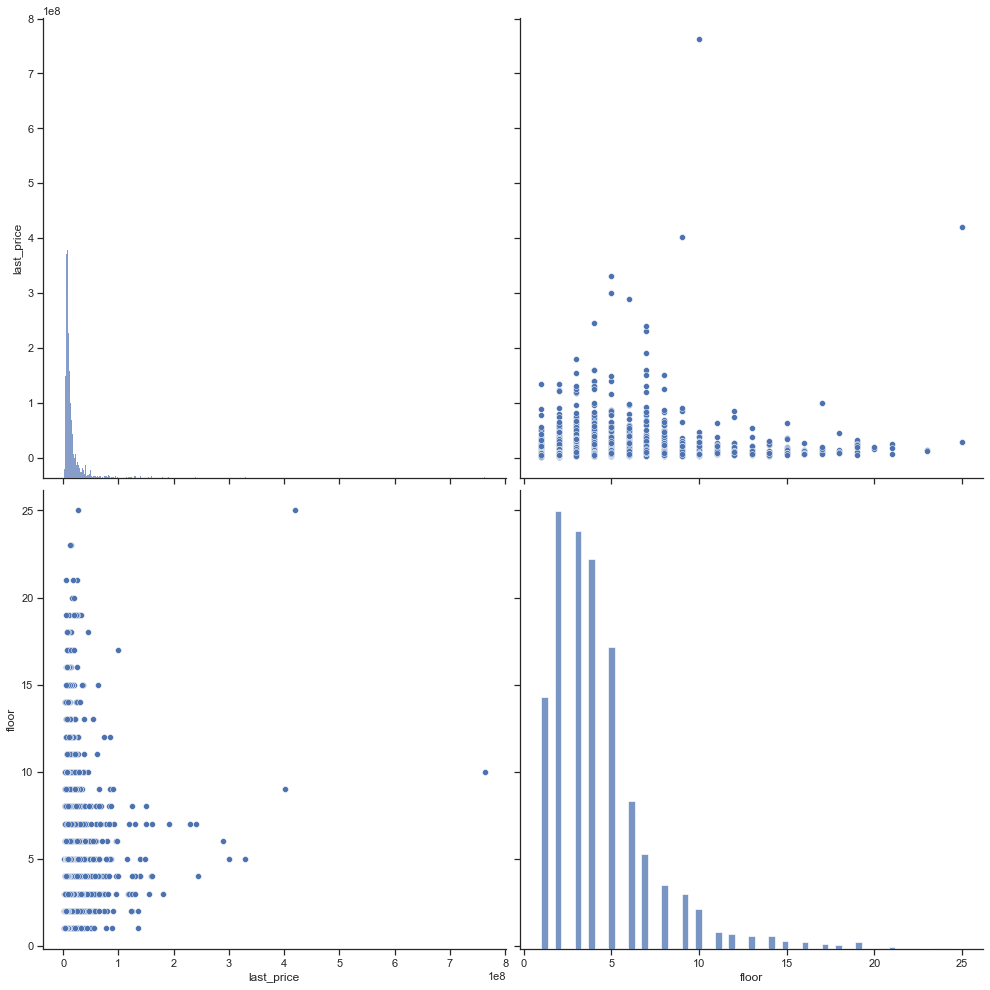

In [491]:
sns.pairplot(data=to_plot,
             vars=['last_price', 'floor'],
             height=7,
             aspect=1,
             )

#### 🔎 удалённость от центра

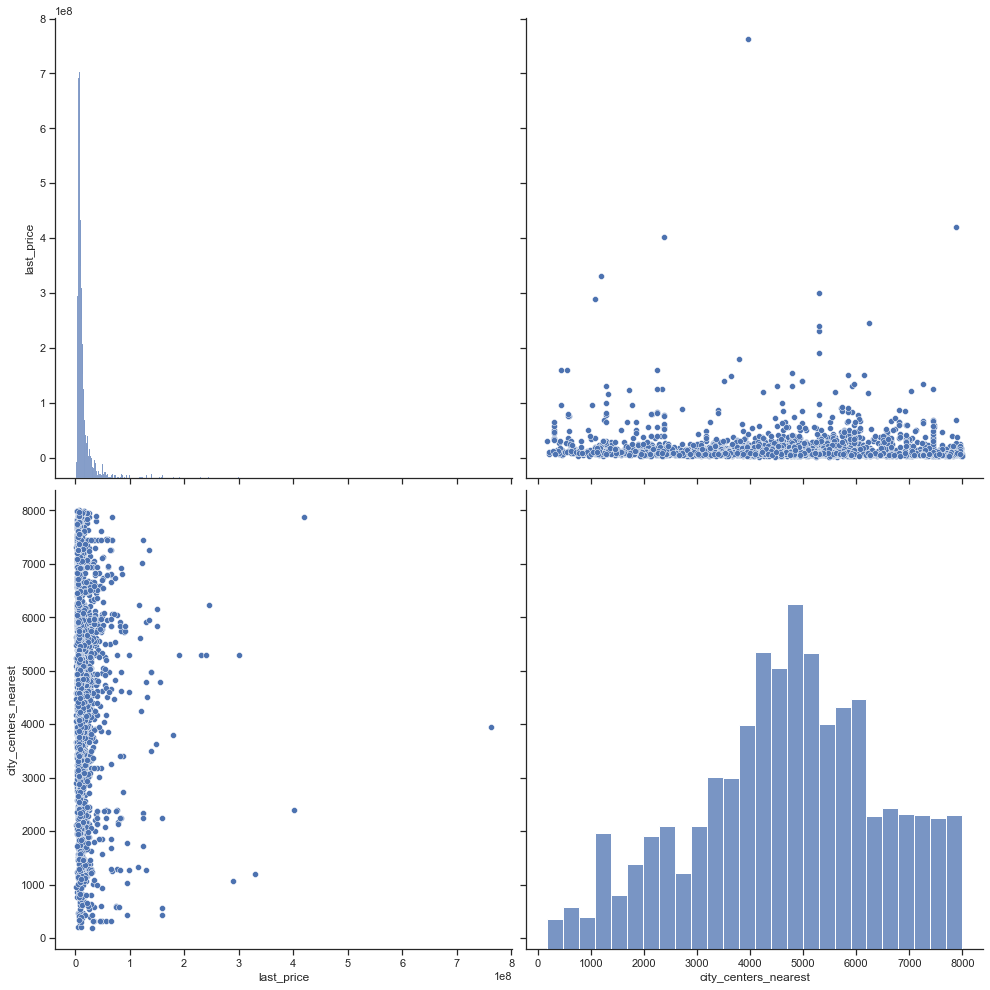

In [492]:
sns.pairplot(data=to_plot,
             vars=['last_price', 'city_centers_nearest'],
             height=7,
             aspect=1,
             )

#### 🔎 дата размещения объявления

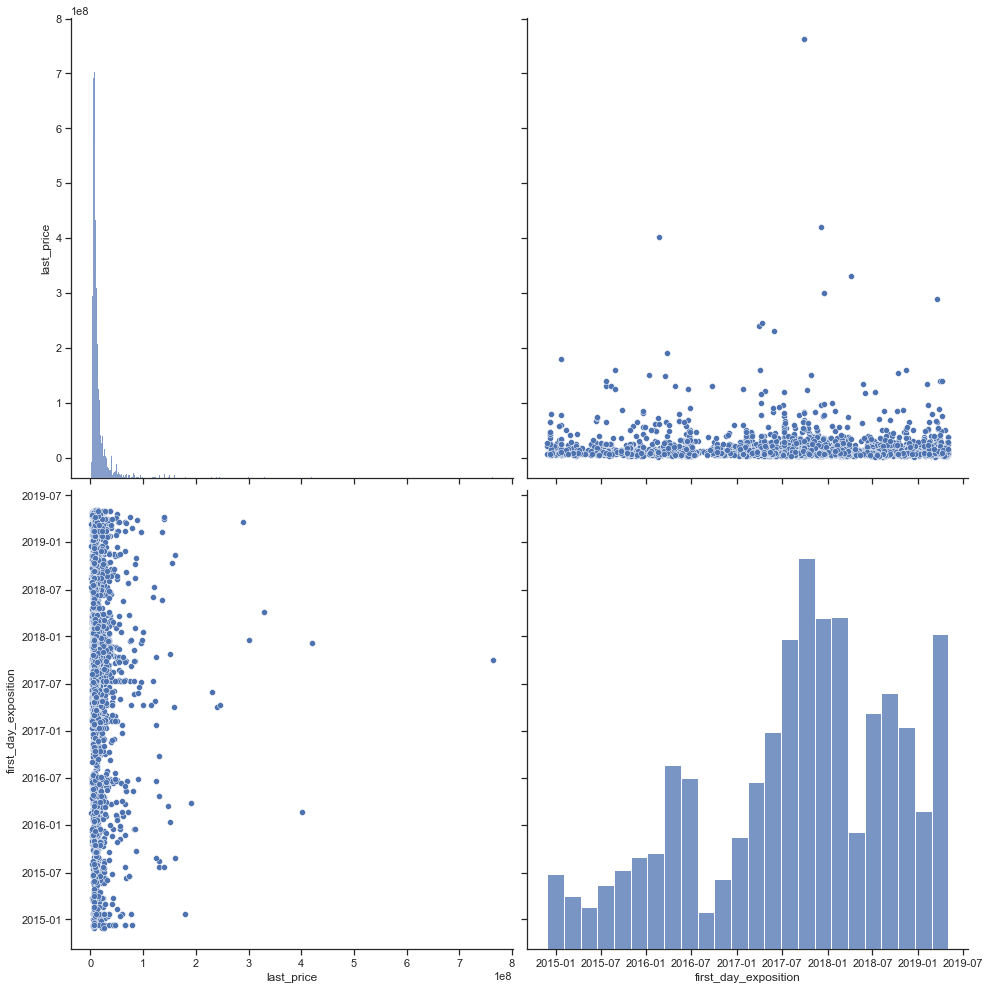

In [493]:
sns.pairplot(data=to_plot,
             vars=['last_price', 'first_day_exposition'],
             height=7,
             aspect=1,
             )

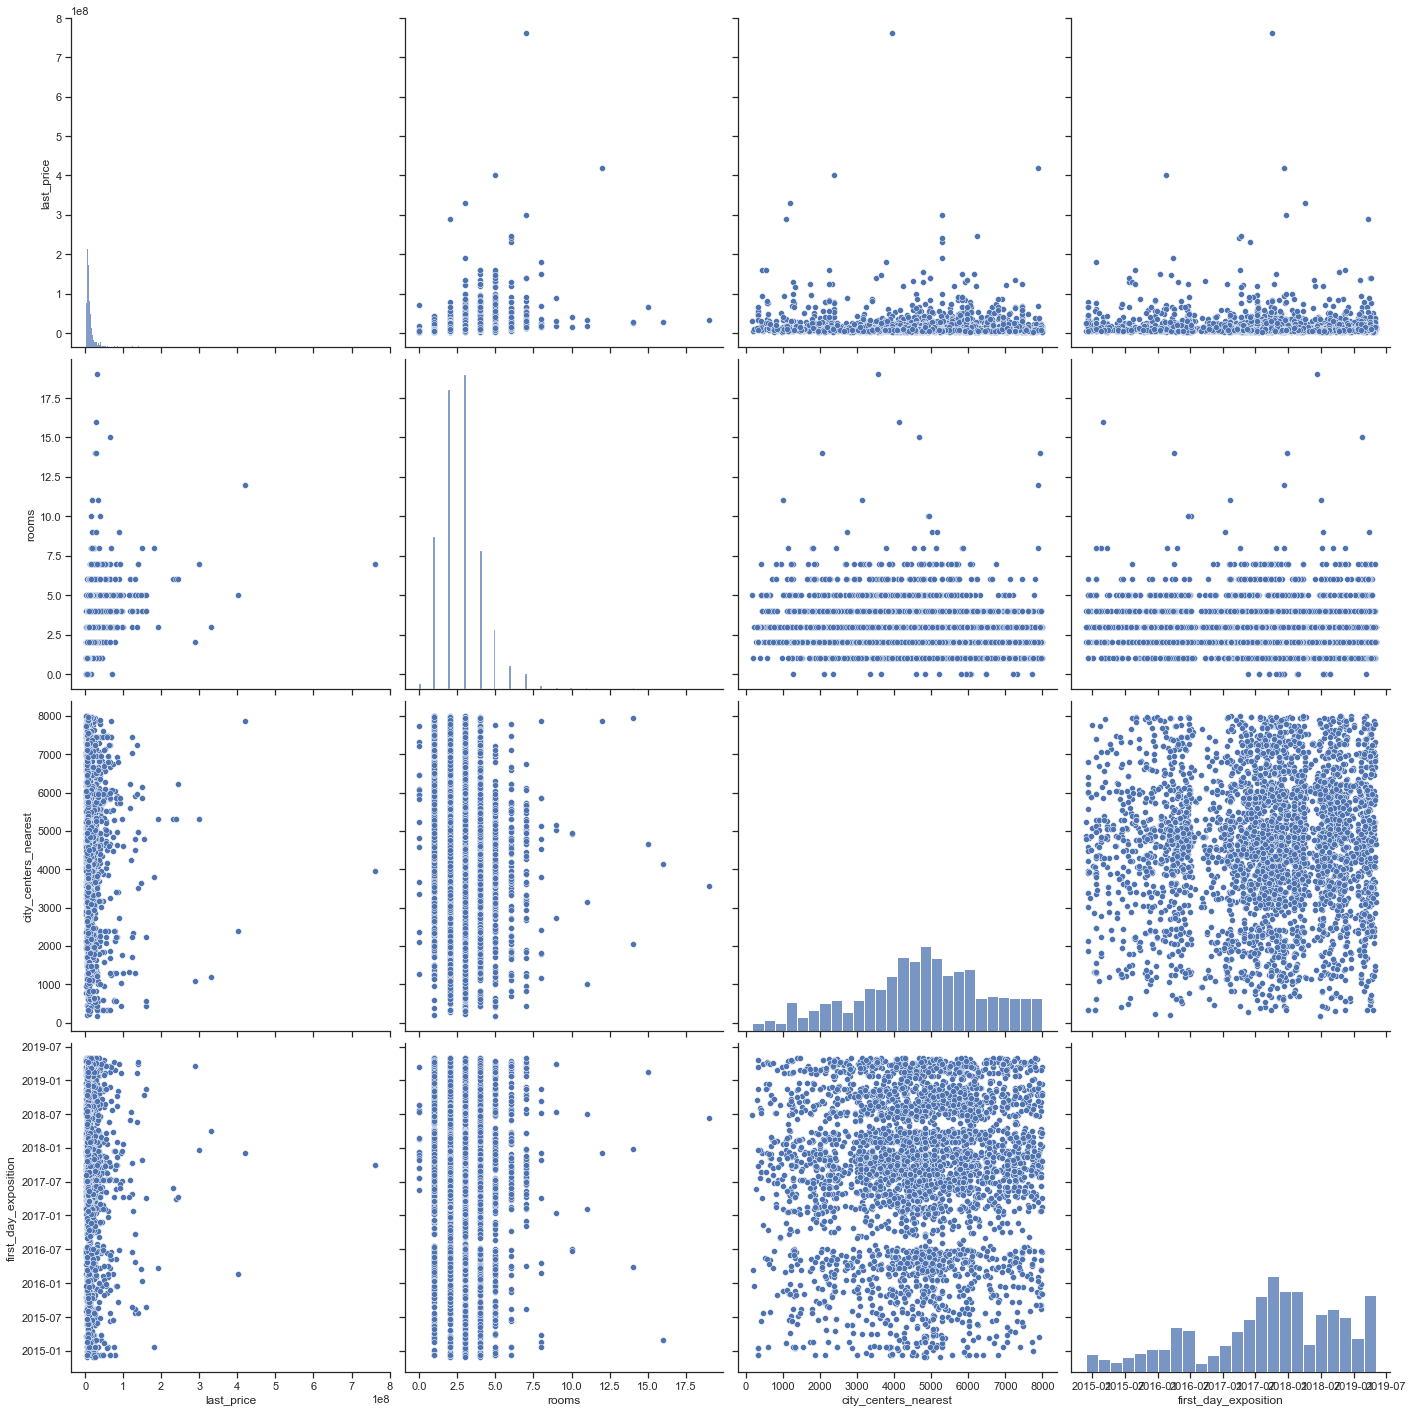

In [494]:
sns.pairplot(data=to_plot,
             vars=['last_price', 'rooms', 'city_centers_nearest', 'first_day_exposition'],
             height=5,
             aspect=1,
             )

## Шаг 5. Общий вывод

## Описание данных

`airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)

`balcony` — число балконов

`ceiling_height` — высота потолков (м)

`cityCenters_nearest` — расстояние до центра города (м)

`days_exposition` — сколько дней было размещено объявление (от публикации до снятия)

`first_day_exposition` — дата публикации

`floor` — этаж

`floors_total` — всего этажей в доме

`is_apartment` — апартаменты (булев тип)

`kitchen_area` — площадь кухни в квадратных метрах (м²)

`last_price` — цена на момент снятия с публикации

`living_area` — жилая площадь в квадратных метрах (м²)

`locality_name` — название населённого пункта

`open_plan` — свободная планировка (булев тип)

`parks_around3000` — число парков в радиусе 3 км

`parks_nearest` — расстояние до ближайшего парка (м)

`ponds_around3000` — число водоёмов в радиусе 3 км

`ponds_nearest` — расстояние до ближайшего водоёма (м)

`rooms` — число комнат

`studio` — квартира-студия (булев тип)

`total_area` — площадь квартиры в квадратных метрах (м²)

`total_images` — число фотографий квартиры в объявлении